In [1]:
import os 
import pandas as pd 
import numpy as np 
from tqdm import tqdm
import cv2
from collections import Counter
from sklearn.metrics import accuracy_score


In [2]:
folder_path = '/kaggle/input/faces-lm/frames'  # Replace with your folder path


In [3]:
folders=sorted(os.listdir(folder_path))

In [4]:
paths=[]
for i in tqdm(range(len(folders))):
    files=os.listdir(os.path.join(folder_path,folders[i]))
    files.sort(key=lambda x: int(x.split('.')[0]))
    files=[os.path.join(folder_path,folders[i],files[j]) for j in range(len(files))]
    paths=paths+files

100%|██████████| 27/27 [00:04<00:00,  6.58it/s]


In [5]:
def get_csv_id(file_path):

    # Extract the filename without extension
    filename = os.path.basename(file_path)  # RightVideoSN001.csv

    # Extract the identifier ('1' or '11')
    if filename.startswith('RightVideoSN'):
        identifier = filename[len('RightVideoSN'):]  # Get '001' or '011'
        identifier = identifier.lstrip('0').split('.')[0]  # Remove leading zeros

    return int(identifier)
def get_id(path):

    # Split the path by '/'
    parts = path.split('/')

    # Get the directory name that contains the image
    dirname = parts[-2]  # RightVideoSN011

    # Extract the relevant parts from the directory name
    if dirname.startswith('RightVideoSN'):
        identifier = dirname[len('RightVideoSN'):]  # Get SN011 -> 011
        identifier = identifier.lstrip('0')  # Remove leading zeros

    # Get the image number from the filename
    filename = parts[-1]  # 240.jpg
    image_number = os.path.splitext(filename)[0]  # 240

    return int(identifier),int(image_number)

In [6]:
folder_path = '/kaggle/input/labels-csv/labels_csv'
csv_path=[]
for root, dirs, files in os.walk(folder_path):
    for file_name in files:
        file_path = os.path.join(root, file_name)
        csv_path.append(file_path)
csv_path=sorted(csv_path)
csv={}
for file in csv_path:
    df=pd.read_csv(file)
    ide=get_csv_id(file)
    csv[ide]=df

In [7]:
labels=[]
for file in tqdm(paths):
    ide,image=get_id(file)
    try:
        label=np.array(csv[ide].iloc[image])
        label[label > 0]=1
        labels.append(label)
    except IndexError as e:
        print(f"IndexError occurred: {ide}")
        print(f"Check ide={ide} and image={image} against csv indices.")
labels=np.array(labels)

100%|██████████| 32723/32723 [00:02<00:00, 14308.56it/s]


In [8]:
for i in range(12):
    print(Counter(labels[:,i]))

Counter({0: 30529, 1: 2194})
Counter({0: 25017, 1: 7706})
Counter({0: 30753, 1: 1970})
Counter({0: 29487, 1: 3236})
Counter({0: 30882, 1: 1841})
Counter({0: 31591, 1: 1132})
Counter({0: 21200, 1: 11523})
Counter({0: 26478, 1: 6245})
Counter({0: 26567, 1: 6156})
Counter({0: 32043, 1: 680})
Counter({0: 27850, 1: 4873})
Counter({0: 30938, 1: 1785})


In [25]:
zero_indices = np.where(~labels.any(axis=1))[0]
nz=np.where(labels.any(axis=1))[0]
print("Indices where all elements in rows are zero:",len(zero_indices))
print("Indices where all elements in rows are all not  zero:",len(nz))

Indices where all elements in rows are zero: 12154
Indices where all elements in rows are all not  zero: 20569


In [30]:
random_numbers = np.random.choice(zero_indices, size=1000, replace=False)
mask=np.concatenate((random_numbers,nz))
mask.sort()

21569

In [34]:
sam_labels=labels[mask]
sam_labels.shape

(21569, 12)

In [37]:
frames=[]
target_size=(224, 224)
for i in tqdm(range(len(paths))):
    if i in mask:
        img=cv2.imread(paths[i],0)
        resized_img = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA)
        rgb_image = cv2.cvtColor(resized_img, cv2.COLOR_GRAY2RGB)
        frames.append(rgb_image)

100%|██████████| 32723/32723 [01:22<00:00, 395.72it/s] 


In [10]:
# w=min([frames[i].shape[0] for i in range(len(frames))])
# h=min([frames[i].shape[1] for i in range(len(frames))])
# w,h

In [11]:
# import cv2
# import random

# def resize_images(image_list):
#     resized_images = []
#     for img in tqdm(image_list):
#         target_size = (250, 239)
#         resized_img = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA)
#         resized_images.append(resized_img)
#     return resized_images

# fr=resize_images(frames)

In [40]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(np.array(frames),sam_labels,test_size=0.2,random_state=42)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((17255, 224, 224, 3), (4314, 224, 224, 3), (17255, 12), (4314, 12))

In [39]:
from tensorflow.keras.applications import EfficientNetB0
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import AUC
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from sklearn.metrics import precision_recall_curve, auc


In [46]:
base_model = EfficientNetB0(include_top=False, input_shape=(224, 224, 3), weights='imagenet')

# Freeze the base model
base_model.trainable = False

# Add custom dense network on top of EfficientNetB0
inputs = Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)

# Second dense layer
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0)(x)

x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0)(x)

# Third dense layer
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0)(x)

# Fourth dense layer
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0)(x)

# Fifth dense layer
x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0)(x)

# Output layer
outputs = Dense(12, activation='sigmoid')(x)  # 12 output labels for multi-label classification

# Create the model
model = Model(inputs, outputs)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0005),
              loss=BinaryCrossentropy(),
              metrics=['mse'])

# Model summary
model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1024)           │     1,311,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 12)             │           780 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,067,311 (23.14 MB)

 Trainable params: 2,013,772 (7.68 MB)

 Non-trainable params: 4,053,539 (15.46 MB)

In [121]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

# Load the InceptionV3 model, excluding the top layer
base_model = InceptionV3(include_top=False, input_shape=(224, 224, 3), weights='imagenet')

# Freeze the base model
# base_model.trainable = False

# Add custom dense network on top of InceptionV3
inputs = Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)

# First dense layer
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0)(x)

# Second dense layer
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0)(x)

# Third dense layer
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0)(x)

# Fourth dense layer
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0)(x)

# Fifth dense layer
x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0)(x)

# Output layer
outputs = Dense(12, activation='sigmoid')(x)  # 12 output labels for multi-label classification

# Create the model
model = Model(inputs, outputs)

# Compile the model
model.compile(optimizer='adam',
              loss=loss,
              metrics=[pr_metric])

# Model summary
model.summary()


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional_39"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_v3 (Functional)       │ (None, 5, 5, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_19     │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_95 (Dense)                │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_94          │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_57 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_96 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_95          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_58 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_97 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_96          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_59 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_98 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_97          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_60 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_99 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_98          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_61 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_100 (Dense)               │ (None, 12)             │           780 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,606,956 (93.87 MB)

 Trainable params: 24,568,556 (93.72 MB)

 Non-trainable params: 38,400 (150.00 KB)

In [122]:
history=model.fit(X_train, y_train,
          epochs=50,
          batch_size=32,
          validation_data=(X_test, y_test),
          verbose=1)

Epoch 1/50
540/540 ━━━━━━━━━━━━━━━━━━━━ 238s 272ms/step - auc_1: 0.7110 - loss: 0.0368 - val_auc_1: 0.8212 - val_loss: 0.0166
Epoch 2/50
540/540 ━━━━━━━━━━━━━━━━━━━━ 83s 153ms/step - auc_1: 0.8387 - loss: 0.0151 - val_auc_1: 0.8850 - val_loss: 0.0132
Epoch 3/50
540/540 ━━━━━━━━━━━━━━━━━━━━ 83s 153ms/step - auc_1: 0.9079 - loss: 0.0112 - val_auc_1: 0.9169 - val_loss: 0.0118
Epoch 4/50
540/540 ━━━━━━━━━━━━━━━━━━━━ 83s 153ms/step - auc_1: 0.9309 - loss: 0.0096 - val_auc_1: 0.9413 - val_loss: 0.0104
Epoch 5/50
540/540 ━━━━━━━━━━━━━━━━━━━━ 83s 153ms/step - auc_1: 0.9393 - loss: 0.0090 - val_auc_1: 0.9401 - val_loss: 0.0103
Epoch 6/50
540/540 ━━━━━━━━━━━━━━━━━━━━ 82s 153ms/step - auc_1: 0.9501 - loss: 0.0080 - val_auc_1: 0.9068 - val_loss: 0.0120
Epoch 7/50
540/540 ━━━━━━━━━━━━━━━━━━━━ 83s 153ms/step - auc_1: 0.9565 - loss: 0.0074 - val_auc_1: 0.9392 - val_loss: 0.0108
Epoch 8/50
540/540 ━━━━━━━━━━━━━━━━━━━━ 83s 153ms/step - auc_1: 0.9578 - loss: 0.0073 - val_auc_1: 0.9173 - val_loss: 0.0118

In [123]:
pred=model.predict(X_test).round()

135/135 ━━━━━━━━━━━━━━━━━━━━ 16s 78ms/step


In [124]:
model.save('incept_v3_full.keras')

au1   :  0.9802967083912842
au12   :  0.9654612888270746
au15   :  0.9844691701437182
au17   :  0.9617524339360223
au2   :  0.9891052387575336
au20   :  0.9858599907278628
au25   :  0.9724153917477979
au26   :  0.9522484932777006
au4   :  0.9768196569309225
au5   :  0.9886416318961521
au6   :  0.9659248956884562
au9   :  0.9879462216040797


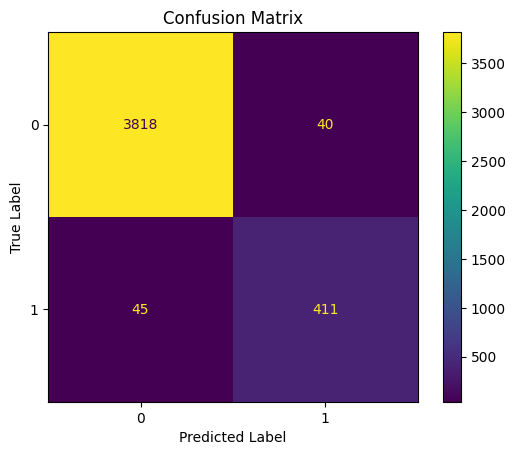

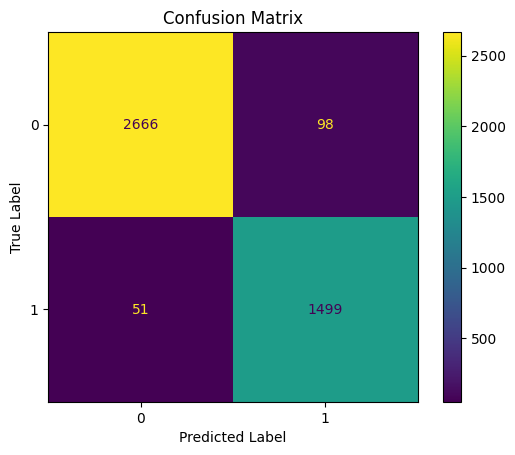

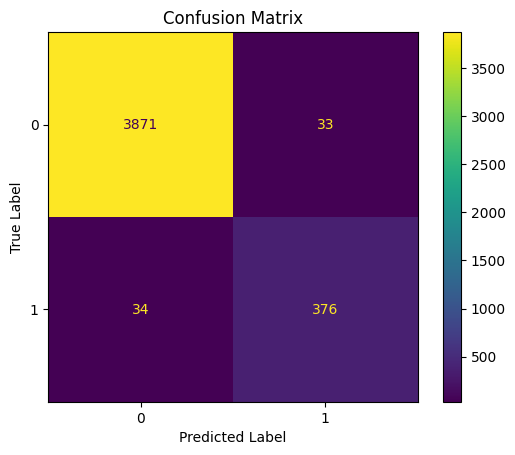

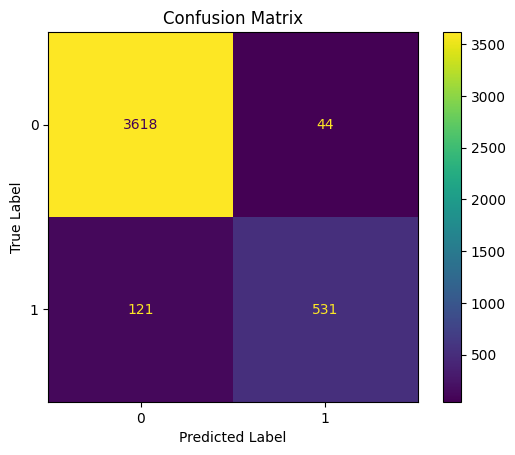

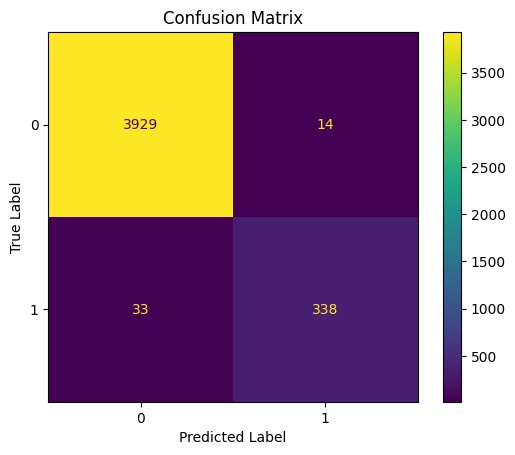

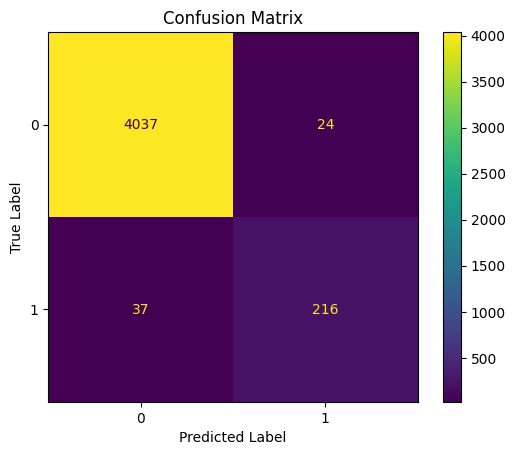

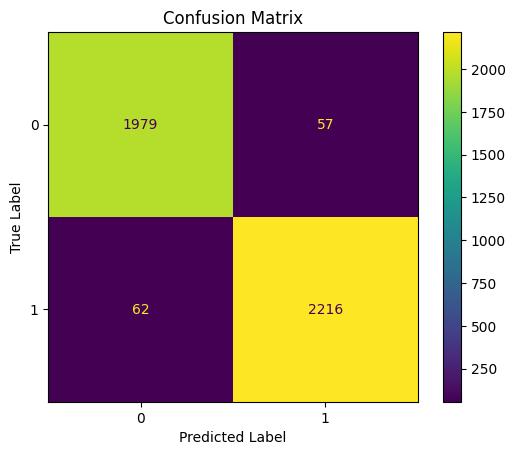

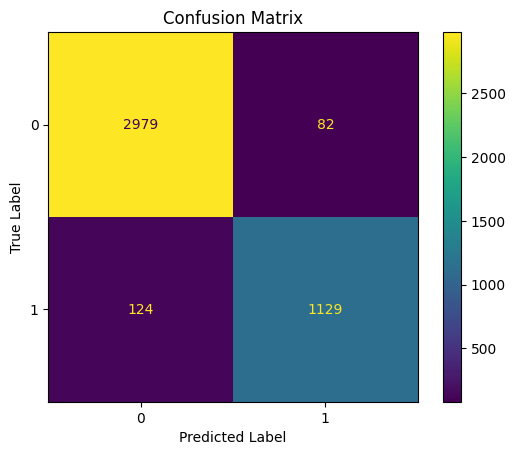

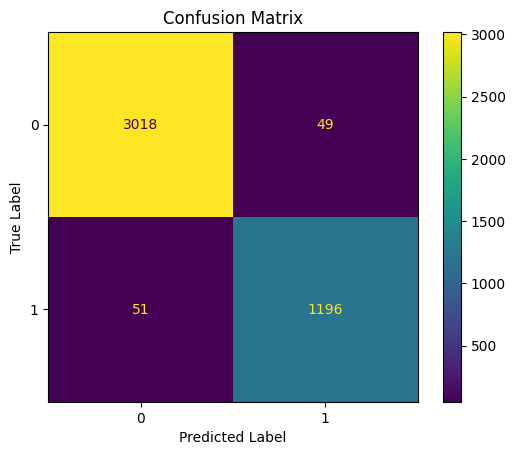

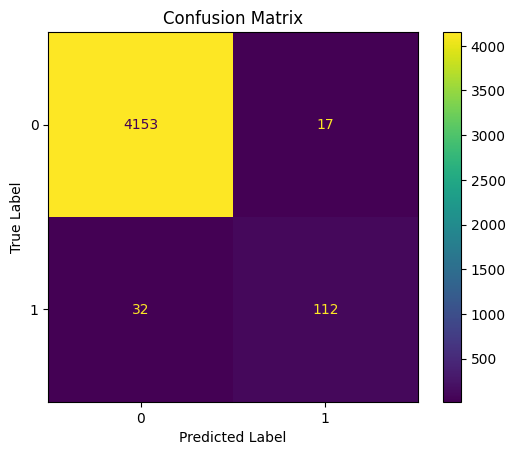

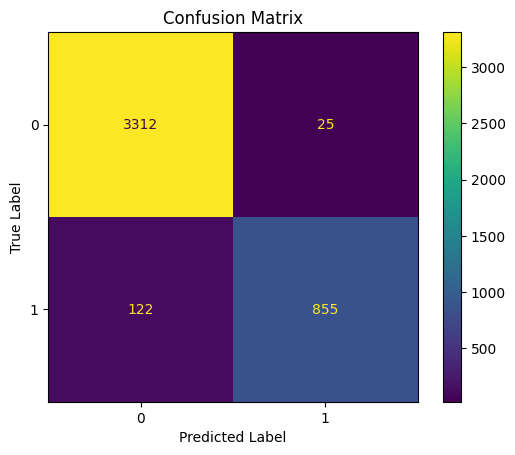

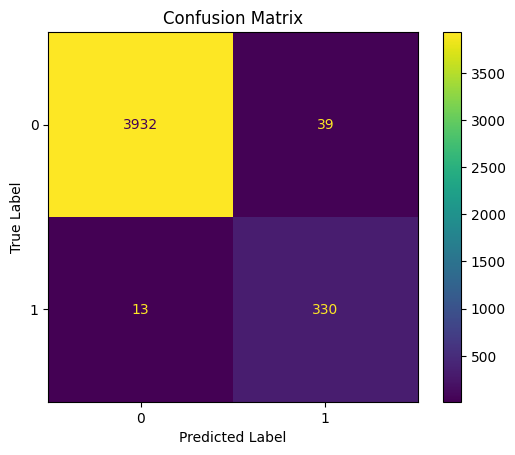

In [125]:
au=csv[1].columns
for i in range(12):
    print(f'{au[i]}   : ',accuracy_score(y_test[:,i],pred[:,i]))
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,classification_report 
import matplotlib.pyplot as plt
for i in range(12):
    cm = confusion_matrix(y_test[:,i], pred[:,i])

    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()

    # Customize the plot (optional)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

In [52]:
model.save("effnet.keras")

In [50]:
# import numpy as np
# import tensorflow as tf
# from sklearn.utils.class_weight import compute_class_weight
# from tensorflow.keras import backend as K
# # Assuming 'labels' is a numpy array with shape (num_samples, 12)
# # Convert labels to a list of arrays, one for each class
# label_list = [labels[:, i] for i in range(12)]

# # Compute class weights for each label
# class_weights = []
# for label in label_list:
#     weight = compute_class_weight('balanced', classes=np.unique(label), y=label)
#     class_weights.append(weight)

# # Convert the list of weights to a dictionary format required by Keras
# class_weights_dict = {}
# for i in range(12):
#     class_weights_dict[i] = {0: class_weights[i][0], 1: class_weights[i][1]}

# def weighted_binary_crossentropy(class_weights):
#     def loss(y_true, y_pred):
#         y_true = K.cast(y_true, y_pred.dtype)
# #         print("Shape of y_true:", y_true.shape)
# #         print("Shape of y_pred:", y_pred.shape)
        
#         weights = tf.zeros_like(y_true)
#         for i in range(y_true.shape[1]):
#             weights += tf.cast(tf.equal(y_true[:, i], 1), y_pred.dtype) * class_weights[i][1]
#             weights += tf.cast(tf.equal(y_true[:, i], 0), y_pred.dtype) * class_weights[i][0]
        
#         bce = K.binary_crossentropy(y_true, y_pred)
# #         print("Shape of bce:", bce.shape)
        
#         weighted_bce = bce * weights
# #         print("Shape of weighted_bce:", weighted_bce.shape)
        
#         return K.mean(weighted_bce)
#     return loss

In [51]:
X_train.shape

(26178, 224, 224, 3)

In [15]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# # Initialize the model
# model = Sequential()

# # Convolutional layers
# model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(239, 250, 1)))
# model.add(MaxPooling2D((2, 2)))
# model.add(Conv2D(64, (3, 3), activation='relu'))
# model.add(MaxPooling2D((2, 2)))
# model.add(Conv2D(128, (3, 3), activation='relu'))
# model.add(MaxPooling2D((2, 2)))

# # Flatten layer
# model.add(Flatten())

# # Dense layers
# model.add(Dense(256, activation='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(128, activation='relu'))
# model.add(Dense(12, activation='sigmoid'))  # Sigmoid for multi-label classification

# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['mse'])
# # Print model summary
# model.summary()


In [16]:
# history = model.fit(X_train,y_train,epochs=20)

In [17]:
# pred=model.predict(X_test).round()
# pred

In [18]:
# for i in range(12):
#     print(accuracy_score(y_test[:,i],pred[:,i]))

In [19]:
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# import matplotlib.pyplot as plt
# for i in range(12):
#     cm = confusion_matrix(y_test[:,i], pred[:,i])

#     # Plot confusion matrix
#     disp = ConfusionMatrixDisplay(confusion_matrix=cm)
#     disp.plot()

#     # Customize the plot (optional)
#     plt.title("Confusion Matrix")
#     plt.xlabel("Predicted Label")
#     plt.ylabel("True Label")
#     plt.show()

In [20]:
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Dropout


# from tensorflow.keras import backend as K

# # Define the custom Hamming loss function
# def hamming_loss(y_true, y_pred):
#     y_true = K.cast(y_true, 'float32')  # Ensure y_true is float32 to match y_pred
#     y_pred = K.round(y_pred)  # Round predictions to nearest integer (0 or 1)
#     tmp = K.abs(y_true - y_pred)
#     return K.mean(tmp, axis=-1)

# # Define the model
# model = Sequential([
#     Dense(1024, activation='relu', input_shape=(2048,)),
#     Dropout(0.5),  # Dropout with rate 0.5
#     Dense(512, activation='relu'),
#     Dropout(0.3),  # Dropout with rate 0.3
#     Dense(256, activation='relu'),
#     Dense(128, activation='relu'),
#     Dropout(0.2),  # Dropout with rate 0.2
#     Dense(12, activation='sigmoid')  # Use sigmoid for multi-label classification
# ])

# # Compile the model
# model.compile(optimizer='adam',
#               loss='binary_crossentropy',  # Binary crossentropy for multi-label classification
#               metrics=[hamming_loss])

# # Summary of the model
# model.summary()


In [21]:
# history = model.fit(X_train, y_train, epochs=1000, batch_size=32, validation_data=(X_test,y_test))

In [22]:
# pred=model.predict(X_test).round()

In [23]:
# for i in range(12):
#     print(accuracy_score(y_test[:,i],pred[:,i]))

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

# Assuming y_train is your multi-label training labels in binary indicator format
# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=np.argmax(y_train, axis=1))

print("Class weights:", class_weights)


In [112]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense,Dropout

# Load MobileNet model with pre-trained weights on ImageNet
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [113]:
from tensorflow.keras.metrics import AUC
pr_metric = AUC(curve='PR', num_thresholds=1000)

import tensorflow as tf
from sklearn.metrics import average_precision_score

def sk_pr_auc(y_true, y_pred):
    return tf.py_function(average_precision_score, (y_true, y_pred), tf.float64)


In [114]:
def binary_focal_loss(gamma=2.0, alpha=0.25):
    def focal_loss(y_true, y_pred):
        # Define epsilon to avoid log(0)
        epsilon = tf.keras.backend.epsilon()
        # Clip predictions to prevent log(0) and log(1 - 0)
        y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)
        # Compute the focal loss
        fl = - alpha * (y_true * (1 - y_pred)**gamma * tf.math.log(y_pred)
                       + (1 - y_true) * (y_pred**gamma) * tf.math.log(1 - y_pred))
        return tf.reduce_mean(fl, axis=-1)
    return focal_loss

loss = binary_focal_loss(gamma=2.0, alpha=0.25)

In [115]:
# Freeze the base model
base_model.trainable = False
# Add a global spatial average pooling layer
x = GlobalAveragePooling2D()(base_model.output)

# Add a dense layer for each label with sigmoid activation
x = Dense(1024, activation='relu')(x)
x = Dropout(0)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0)(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(12, activation='sigmoid')(x)  # 12 output labels, sigmoid activation

# Combine base model and custom layers
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam',
              loss=loss,
              metrics=[pr_metric])

In [116]:
from tensorflow.keras.callbacks import EarlyStopping

# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=9, restore_best_weights=True)

# Add the callback to the list of callbacks
callbacks = [early_stopping]

history=model.fit(X_train, y_train,
          epochs=50,
          batch_size=32,
          validation_data=(X_test, y_test),
          verbose=1,
        )

Epoch 1/50
540/540 ━━━━━━━━━━━━━━━━━━━━ 25s 34ms/step - auc_1: 0.5099 - loss: 0.0258 - val_auc_1: 0.7513 - val_loss: 0.0190
Epoch 2/50
540/540 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - auc_1: 0.7702 - loss: 0.0179 - val_auc_1: 0.8020 - val_loss: 0.0173
Epoch 3/50
540/540 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - auc_1: 0.8139 - loss: 0.0159 - val_auc_1: 0.8287 - val_loss: 0.0159
Epoch 4/50
540/540 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - auc_1: 0.8337 - loss: 0.0150 - val_auc_1: 0.8463 - val_loss: 0.0148
Epoch 5/50
540/540 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - auc_1: 0.8587 - loss: 0.0137 - val_auc_1: 0.8646 - val_loss: 0.0137
Epoch 6/50
540/540 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - auc_1: 0.8742 - loss: 0.0129 - val_auc_1: 0.8419 - val_loss: 0.0150
Epoch 7/50
540/540 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - auc_1: 0.8817 - loss: 0.0125 - val_auc_1: 0.8587 - val_loss: 0.0141
Epoch 8/50
540/540 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - auc_1: 0.8921 - loss: 0.0119 - val_auc_1: 0.8822 - val_loss: 0.0127
Epoch 9/

In [117]:
model.save('facs_mobile_net_pr_freze.keras')

In [118]:
au=csv[1].columns

In [119]:
au=csv[1].columns
pred=model.predict(X_test).round()
for i in range(12):
    print(f'{au[i]}   : ',accuracy_score(y_test[:,i],pred[:,i]))

135/135 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step
au1   :  0.9654612888270746
au12   :  0.9156235512285582
au15   :  0.96105702364395
au17   :  0.9246638850254983
au2   :  0.9779786740843764
au20   :  0.9700973574408901
au25   :  0.9086694483078349
au26   :  0.9040333796940194
au4   :  0.93115438108484
au5   :  0.9726471951784886
au6   :  0.9369494668521094
au9   :  0.9694019471488178


au1   :  0.9654612888270746
au12   :  0.9156235512285582
au15   :  0.96105702364395
au17   :  0.9246638850254983
au2   :  0.9779786740843764
au20   :  0.9700973574408901
au25   :  0.9086694483078349
au26   :  0.9040333796940194
au4   :  0.93115438108484
au5   :  0.9726471951784886
au6   :  0.9369494668521094
au9   :  0.9694019471488178


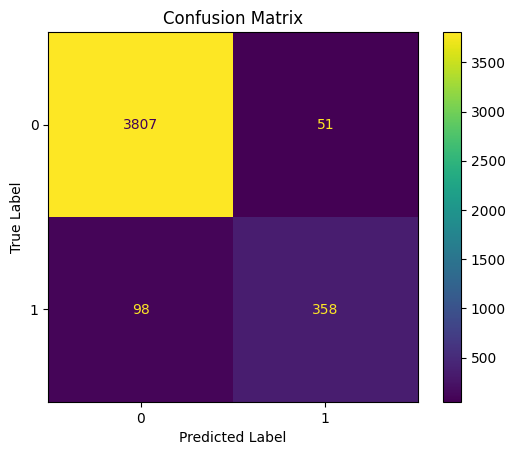

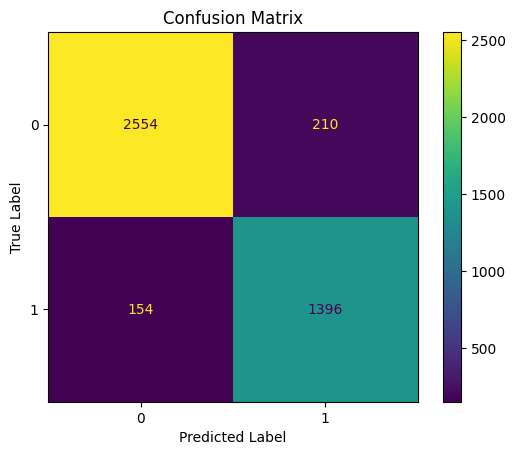

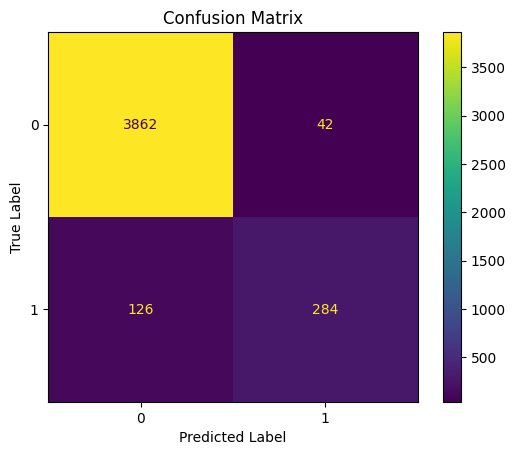

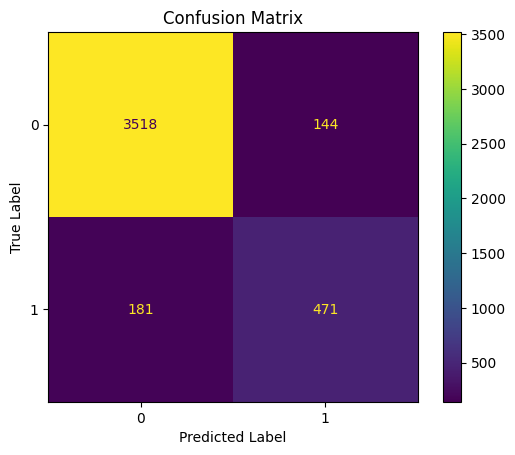

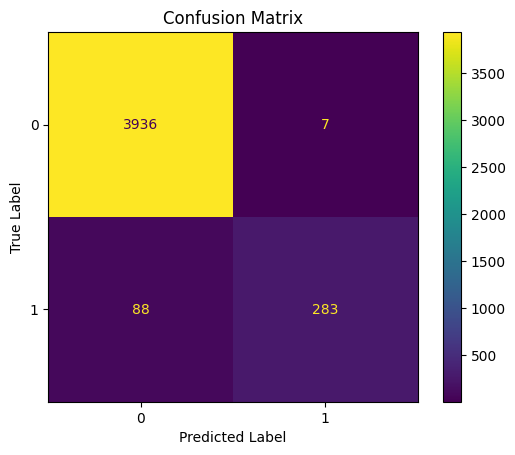

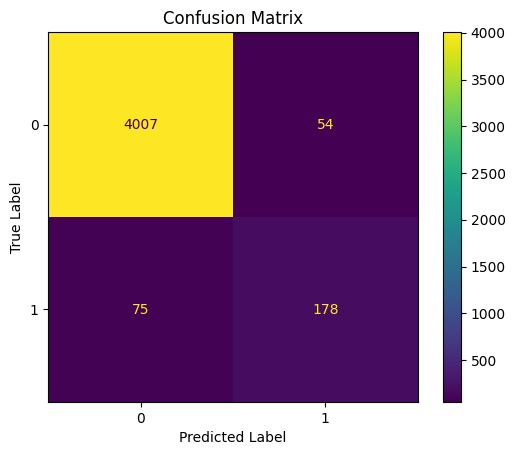

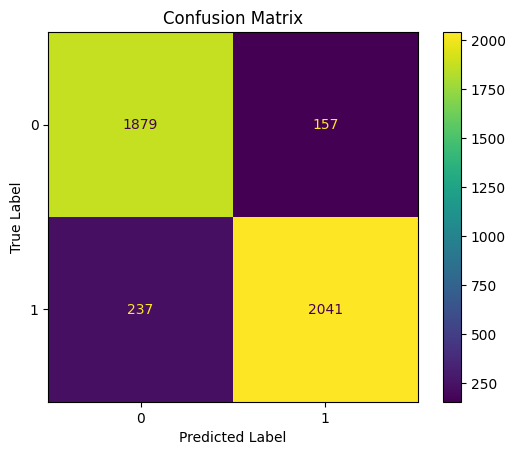

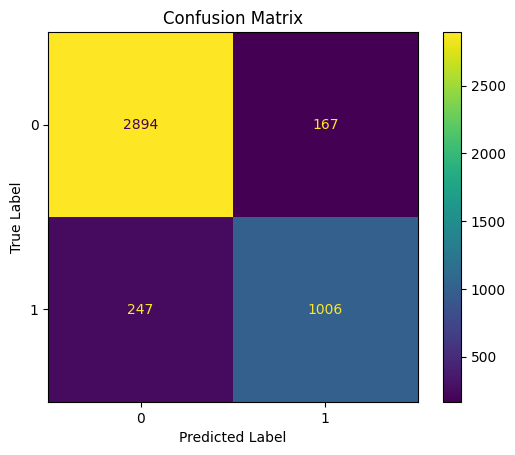

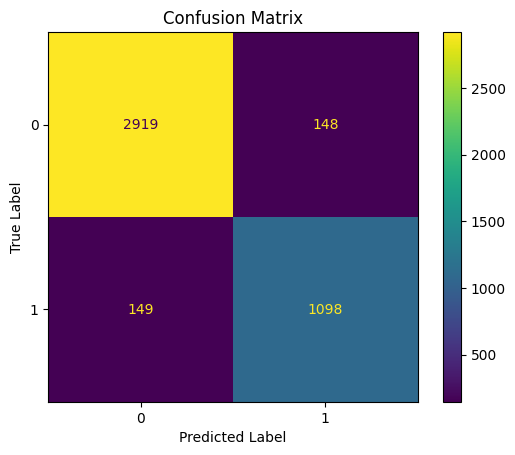

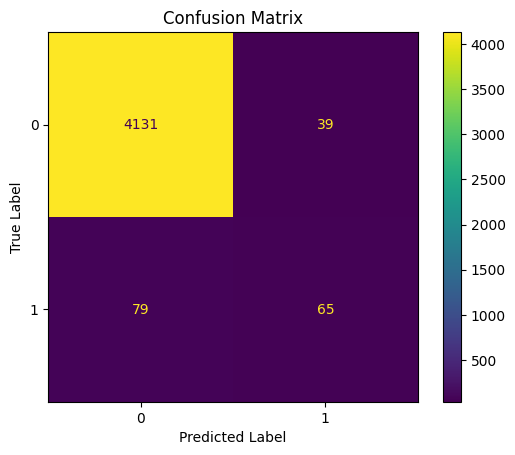

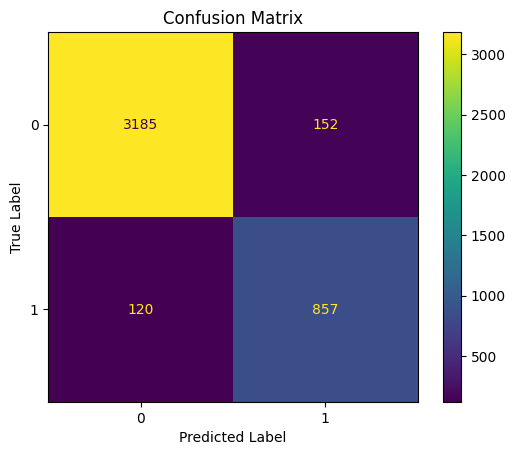

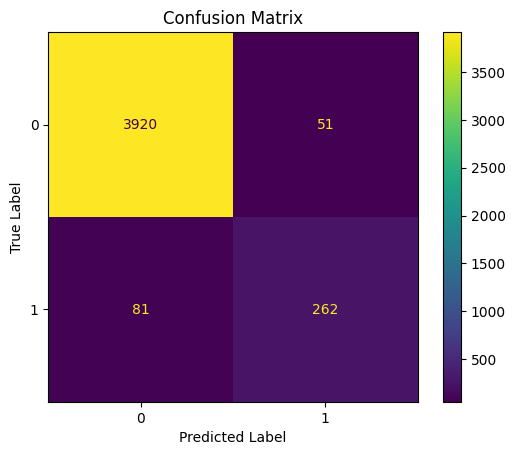

In [120]:
au=csv[1].columns
for i in range(12):
    print(f'{au[i]}   : ',accuracy_score(y_test[:,i],pred[:,i]))
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,classification_report 
import matplotlib.pyplot as plt
for i in range(12):
    cm = confusion_matrix(y_test[:,i], pred[:,i])

    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()

    # Customize the plot (optional)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

In [38]:
for i in range(12):
    print(f'{au[i]}   : ',classification_report(y_test[:,i],pred[:,i]))

au1   :                precision    recall  f1-score   support

           0       0.99      1.00      0.99      6107
           1       0.94      0.85      0.89       438

    accuracy                           0.99      6545
   macro avg       0.97      0.92      0.94      6545
weighted avg       0.99      0.99      0.99      6545

au12   :                precision    recall  f1-score   support

           0       0.98      0.98      0.98      5014
           1       0.92      0.94      0.93      1531

    accuracy                           0.97      6545
   macro avg       0.95      0.96      0.96      6545
weighted avg       0.97      0.97      0.97      6545

au15   :                precision    recall  f1-score   support

           0       0.99      0.99      0.99      6140
           1       0.90      0.91      0.90       405

    accuracy                           0.99      6545
   macro avg       0.94      0.95      0.95      6545
weighted avg       0.99      0.99      0.99  

In [ ]:
import matplotlib.pyplot as plt

# Assuming `history` is the variable holding the history object from model.fit
# Plotting the loss
plt.figure(figsize=(12, 4))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# MSE plot
plt.subplot(1, 2, 2)
plt.plot(history.history['mse'], label='Train MSE')
plt.plot(history.history['val_mse'], label='Validation MSE')
plt.title('Mean Squared Error')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()

plt.show()


In [ ]:
plt.savefig('confusion_matrix.jpg', format='jpg')


In [ ]:
pred=model.predict(X_train).round()

In [ ]:
# from sklearn.ensemble import RandomForestClassifier
# rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
# rf_model.fit(X_train, y_train)
# y_pred = rf_model.predict(X_test)

In [ ]:
# for i in range(12):
#     print(accuracy_score(y_test[:,i],y_pred[:,i]))

In [ ]:
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,classification_report
# import matplotlib.pyplot as plt
# for i in range(12):
#     cm = confusion_matrix(y_test[:,i], y_pred[:,i])

#     # Plot confusion matrix
#     disp = ConfusionMatrixDisplay(confusion_matrix=cm)
#     disp.plot()

#     # Customize the plot (optional)
#     plt.title("Confusion Matrix")
#     plt.xlabel("Predicted Label")
#     plt.ylabel("True Label")
#     plt.show()